In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import tensorflow as tf
import tensorboard as tb
import os
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
# device = 'cpu'

In [3]:
if torch.cuda.is_available():
    print("If cuda is available: ", torch.cuda.is_available())
    device = 'cuda'
    print("Using 'cuda'!!!")
    print(torch.cuda.get_device_name())
else:
    device = 'cpu'
    print("Using CPU!!!")

If cuda is available:  True
Using 'cuda'!!!
NVIDIA GeForce RTX 2060


In [4]:
number_of_layers = 160

In [5]:
!pwd

/home/raylend/Science/NeuralNets/CourseWork/Dataset/PrimaryGamma


# Prepare dataset

In [6]:
train_folders = ['100MeV/1d-check/',
                 '1GeV/1d-check/',
                 '10GeV/1d-check/',
                 '100GeV/1d-check/',
                 '1TeV/1d-check/']
validation_folders= [
    '300MeV/1d-check/',
    '3GeV/1d-check/',
    '30GeV/1d-check/',
    '300GeV/1d-check/'
]
train_energies = torch.tensor([
    1.0e+08,
    1.0e+09, 
    1.0e+10,
    1.0e+11,
    1.0e+12],
    dtype=torch.float
)
validation_energies = torch.tensor([
    3.0e+08,
    3.0e+09, 
    3.0e+10,
    3.0e+11],
    dtype=torch.float
)

In [7]:
train_number_of_samples = [
    3000,
    3000,
    3000,
    3000,
    3000
]
validation_number_of_samples = [
    870,
    870,
    870,
    870
]

In [8]:
y = torch.tensor([])
y_validation = torch.tensor([])
for i, energy in enumerate(train_energies):
    y = torch.cat([y,
                   torch.ones(train_number_of_samples[i]) * energy])

for i, energy  in enumerate(validation_energies):
    y_validation = torch.cat([y_validation,
                              torch.ones(validation_number_of_samples[i]) * energy])

In [9]:
y.shape

torch.Size([15000])

In [10]:
X = torch.zeros((sum(train_number_of_samples),
                 number_of_layers))
X_validation = torch.zeros((sum(validation_number_of_samples),
                            number_of_layers))

In [11]:
X.shape

torch.Size([15000, 160])

In [12]:
shifter = 0
for energy_number in range(0, len(train_energies)):
    print(train_folders[energy_number])
    for i in range(0, train_number_of_samples[energy_number]):
        path = "%04d.txt" % i
        path = train_folders[energy_number] + path
        X[shifter + i, :] = torch.tensor(np.loadtxt(
            path
        ), dtype=torch.float)
    shifter += train_number_of_samples[energy_number]

100MeV/1d-check/
1GeV/1d-check/
10GeV/1d-check/
100GeV/1d-check/
1TeV/1d-check/


In [13]:
shifter = 0
for energy_number in range(0, len(validation_energies)):
    print(validation_folders[energy_number])
    for i in range(0, validation_number_of_samples[energy_number]):
        path = "%04d.txt" % i
        path = validation_folders[energy_number] + path
        X_validation[shifter + i, :] = torch.tensor(np.loadtxt(
            path
        ), dtype=torch.float)
    shifter += validation_number_of_samples[energy_number]

300MeV/1d-check/
3GeV/1d-check/
30GeV/1d-check/
300GeV/1d-check/


# Custom dataset

In [14]:
class CustomDataset(Dataset):
    # see https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    def __init__(self, energies, data,
                 transform=None, target_transform=None,
                 device=None):
        self.energies = energies
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.energies)

    def __getitem__(self, idx):
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return self.data[idx, :], self.energies[idx]

In [15]:
full_dataset = CustomDataset(y, X)

In [16]:
validation_dataset = CustomDataset(y_validation, X_validation)

In [17]:
batch_size = 256

In [18]:
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False,
                              num_workers=3)
fullloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=3)

# Create a model

In [19]:
class NNEnergyRegressor_v9(nn.Module):

    def __init__(self):
        super().__init__() 
        self.activation = nn.functional.relu
        self.recom_gain = nn.init.calculate_gain("relu", param=None)
        self.fc1 = nn.Linear(160, 96)
        torch.nn.init.xavier_normal_(self.fc1.weight, gain=self.recom_gain)
        self.fc2 = nn.Linear(96, 64)
        torch.nn.init.xavier_normal_(self.fc2.weight, gain=self.recom_gain)
        self.fc3 = nn.Linear(64, 32)
        torch.nn.init.xavier_normal_(self.fc3.weight, gain=self.recom_gain)
        self.fc4 = nn.Linear(32, 1)
        torch.nn.init.xavier_normal_(self.fc4.weight, gain=self.recom_gain)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        out = self.fc4(x)
        return out.reshape(out.shape[0])

In [20]:
model = NNEnergyRegressor_v9().to(device)
model.load_state_dict(torch.load("RegressorNN_v9-9-3000-36cm.pt"))
print(model)

NNEnergyRegressor_v9(
  (fc1): Linear(in_features=160, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [21]:
for images, values in validationloader:
    images, values = images.to('cuda'), values.to('cuda')
    outputs = model(images)
    print(outputs.shape)
    print(images.shape)
    print(values.shape)
    break

torch.Size([256])
torch.Size([256, 160])
torch.Size([256])


# Custom loss function

In [22]:
class RelativeLoss(nn.Module):
    
    def __init__(self):
        super(RelativeLoss, self).__init__()
    
    def forward(self, outputs, values):
        # reshape tensors to give a flat vector of length batch_size*seq_len
        return (torch.sum(torch.abs(values - outputs) / values) / values.shape[0])

# Validation

## Validation function

In [24]:
def get_half_width_68(model, loader, energies):
    returned_energies = list()
    half_width_68 = list()
    for ne, energy in enumerate(energies):
        returned_energies.append([])
    with torch.no_grad():
        for images, values in loader:
            ftlist = []
            for image in images: # remove events without signal in detector
                if torch.sum(image[0:36]) <= 0:
                    ftlist.append(False)
                else:
                    ftlist.append(True)
            images = images[ftlist]
            values = values[ftlist]
            images, values = images.to(device), values.to(device)
            outputs = np.array(model(images).detach().to('cpu'))
            values = np.array(values.detach().to('cpu'))
            for i, energy in enumerate(values):
                x = np.where(energy == energies)[0]
                ne = int(x)
                returned_energies[ne].append(outputs[i])
        for ne, energy in enumerate(energies):
            E1 = np.quantile(returned_energies[ne],
                             q=[0.158, ], keepdims=True)
            E2 = np.quantile(returned_energies[ne],
                             q=[1.0 - 0.158, ], keepdims=True)
            half_width_68.append((E2 - E1) / 2.0 / energy.numpy())
    return (np.array(half_width_68)).flatten()

## Bootstrap function

In [25]:
def bootstrap_metric_energy_specific(
    model,
    y, 
    X,
    energies,
    samples_cnt=1000,
    alpha=0.05,
    random_state=333
):
    np.random.seed(random_state)
    
    b_metric = np.zeros((samples_cnt,
                        len(energies)))
    for it in range(0, samples_cnt):
        poses = np.random.choice(X.shape[0], 
                                 size=X.shape[0],
                                 replace=True)
        X_boot = X[poses]
        y_boot = y[poses]
        dataset = CustomDataset(y_boot, X_boot)
        
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=3)
        ### b_metric[it, :], _ = validate_energy_specific(model, dataloader, energies)
        b_metric[it, :] = get_half_width_68(model, dataloader, energies)
        print(it)
    
    
    return np.quantile(b_metric, q=[alpha/2, 1.0 - alpha/2], axis=0, keepdims=True)

## Calculations

In [26]:
energy_resolution_validation_low, energy_resolution_validation_high = bootstrap_metric_energy_specific(
    model,
    y_validation, 
    X_validation,
    validation_energies,
    samples_cnt=1000,
    alpha=0.05,
    random_state=333
)
print(energy_resolution_validation_low,
      energy_resolution_validation_high)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
energy_resolution_validation_median, energy_resolution_validation_median2 = bootstrap_metric_energy_specific(
    model,
    y_validation, 
    X_validation,
    validation_energies,
    samples_cnt=1000,
    alpha=1.0,
    random_state=333
)
print(energy_resolution_validation_median,
      energy_resolution_validation_median2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
energy_resolution_test_low, energy_resolution_test_high = bootstrap_metric_energy_specific(
    model,
    y, 
    X,
    train_energies,
    samples_cnt=1000,
    alpha=0.05,
    random_state=333
)
print(energy_resolution_test_low,
      energy_resolution_test_high)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
energy_resolution_test_median, energy_resolution_test_median2 = bootstrap_metric_energy_specific(
    model,
    y, 
    X,
    train_energies,
    samples_cnt=1000,
    alpha=1.0,
    random_state=333
)
print(energy_resolution_test_median,
      energy_resolution_test_median2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [30]:
energies = np.concatenate([validation_energies,
                           train_energies])
energy_resolution_low = np.concatenate([energy_resolution_validation_low.reshape(validation_energies.shape),
                                        energy_resolution_test_low.reshape(train_energies.shape)])
energy_resolution_high = np.concatenate([energy_resolution_validation_high.reshape(validation_energies.shape),
                                         energy_resolution_test_high.reshape(train_energies.shape)])

In [31]:
energy_resolution_median = np.concatenate([energy_resolution_validation_median.reshape(validation_energies.shape),
                                           energy_resolution_test_median.reshape(train_energies.shape)])

In [32]:
argsorted = np.argsort(energies)
energies = energies[argsorted]
energy_resolution_low = energy_resolution_low[argsorted]
energy_resolution_high = energy_resolution_high[argsorted]

In [33]:
energy_resolution_median = energy_resolution_median[argsorted]

# Plot and compare

In [34]:
def energy_resolution_interpolated_low(e):
    return(interpolate.interp1d(
        np.log10(energies),
        energy_resolution_low,
        kind='cubic',
        copy=True,
        bounds_error=False,
        fill_value='extrapolate')(np.log10(e)))

In [35]:
def energy_resolution_interpolated_high(e):
    return(interpolate.interp1d(
        np.log10(energies),
        energy_resolution_high,
        kind='cubic',
        copy=True,
        bounds_error=False,
        fill_value='extrapolate')(np.log10(e)))

In [36]:
def energy_resolution_interpolated_median(e):
    return(interpolate.interp1d(
        np.log10(energies),
        energy_resolution_median,
        kind='cubic',
        copy=True,
        bounds_error=False,
        fill_value='extrapolate')(np.log10(e)))

In [37]:
energy_resolution_old = np.loadtxt(
    "MAST_energy_resolution_Mev_percent.txt"
)
energy_resolution_old[:, 0] = energy_resolution_old[:, 0] * 1.0e+06
energy_resolution_fermi = np.loadtxt(
    "Fermi_LAT_energy_resolution_MeV_percent.txt"
)
energy_resolution_fermi[:, 0] = energy_resolution_fermi[:, 0] * 1.0e+06

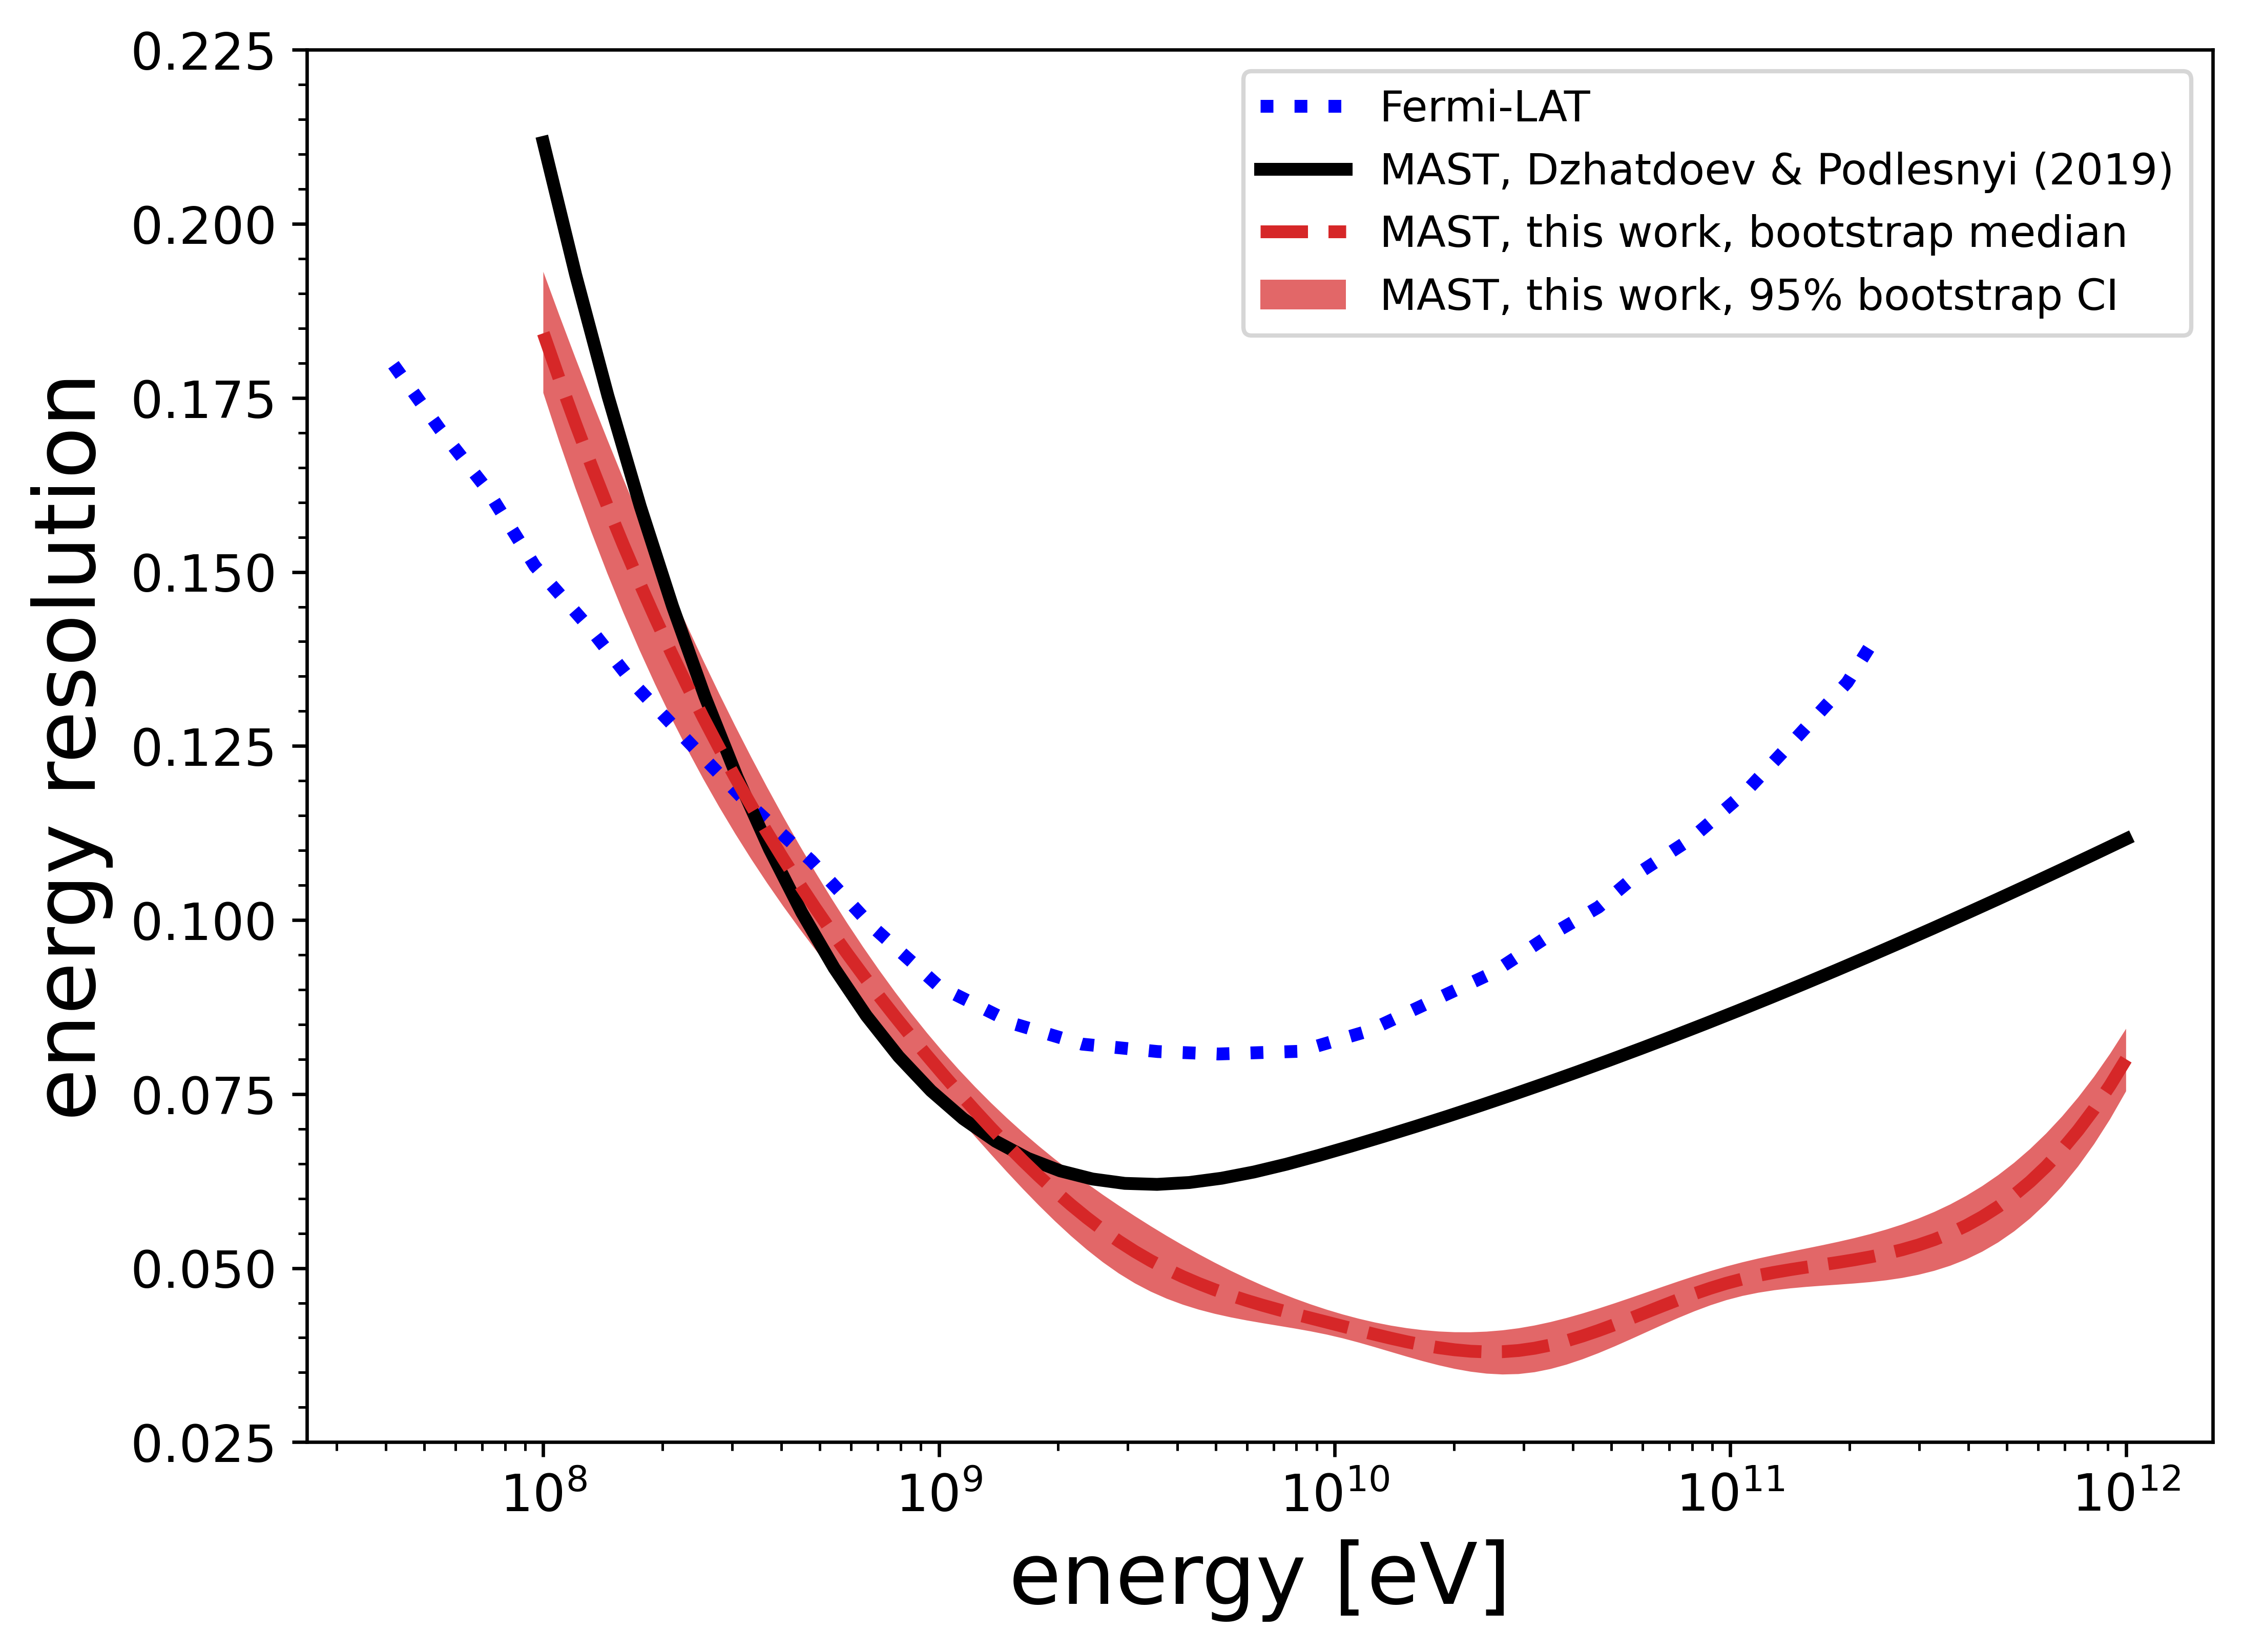

In [62]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

plt.fill_between(
    np.logspace(8, 12, 100),
    energy_resolution_interpolated_low(np.logspace(8, 12, 100)),
    energy_resolution_interpolated_high(np.logspace(8, 12, 100)),
    linestyle='-',
    linewidth=3,
    label='MAST, this work, 95% bootstrap CI',
    facecolor="tab:red",
    alpha=0.7,
)

plt.plot(
    energy_resolution_fermi[:, 0], energy_resolution_fermi[:, 1],
    marker=None,
    linestyle=':',
    linewidth=3,
    label='Fermi-LAT',
    color='b'
)

plt.plot(
    energy_resolution_old[:, 0], energy_resolution_old[:, 1],
    marker=None,
    linestyle='-',
    linewidth=3,
    label='MAST, Dzhatdoev & Podlesnyi (2019)',
    color='k'
)

plt.plot(
    np.logspace(8, 12, 100),
    energy_resolution_interpolated_median(np.logspace(8, 12, 100)),
    linestyle='--',
    linewidth=3,
    color="tab:red",
    label='MAST, this work, bootstrap median'
)

plt.xlabel('energy ' + '[eV]', fontsize=20)
plt.xticks(fontsize=12)
plt.ylabel('energy resolution', fontsize=20)
plt.yticks(fontsize=12)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xscale('log')
plt.ylim(0.025, 0.225)
# ax.set_yscale('log')
plt.legend(fontsize=10) 
plt.show()
# fig.savefig('NN_energy_resolution_v9-3000-36cm-bootstrap.pdf')
# fig.savefig('NN_energy_resolution_v9-3000-36cm-bootstrap.png')

In [60]:
my_array = np.concatenate([energies.reshape(energies.shape[0], 1),
                           energy_resolution_median.reshape(energy_resolution_median.shape[0], 1)], axis=1)
my_array

array([[1.00000000e+08, 1.84292074e-01],
       [3.00000000e+08, 1.21295020e-01],
       [1.00000000e+09, 7.85028317e-02],
       [3.00000000e+09, 5.30182480e-02],
       [1.00000000e+10, 4.19443670e-02],
       [3.00000010e+10, 3.82485154e-02],
       [9.99999980e+10, 4.79834585e-02],
       [2.99999986e+11, 5.33517041e-02],
       [9.99999996e+11, 8.00147292e-02]])

In [61]:
# np.savetxt("gamma-ALP/NN_energy_resolution_v9-3000-36cm-bootstrap.txt", my_array, fmt="%.6e")